<a href="https://colab.research.google.com/github/Bambani2003/Data_Science_Projects/blob/main/Time_Series_Analysis/Rainfall_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analysing and Predicting the Precipitation Data using Long Short Term Memory**

In [1]:
# Importing the modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import itertools
import warnings
warnings.filterwarnings('ignore')

**EDA**

In [2]:
# Reading and converting the input data

rainfall_data_matrix = pd.read_csv('/content/pune_1965_to_2002.csv')
rainfall_data_matrix.set_index('Year', inplace=True)
rainfall_data_matrix = rainfall_data_matrix.transpose()
rainfall_data_matrix

Year,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,...,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002
Jan,0.029,0.905,0.248,0.318,0.248,0.070,0.000,0.000,0.000,0.000,...,0.000,0.879,0.695,0.016,1.284,0.008,0.000,0.000,0.147,0.231
Feb,0.069,0.000,3.390,3.035,2.524,0.000,0.000,0.029,2.969,0.000,...,0.078,0.325,0.000,2.779,0.000,2.671,1.431,0.170,0.000,0.911
Mar,0.000,0.000,1.320,1.704,0.334,0.001,0.000,0.000,0.234,6.427,...,1.211,2.415,1.770,0.087,0.747,0.073,0.000,0.000,2.178,0.388
Apr,21.667,2.981,13.482,23.307,4.569,16.218,0.812,5.982,3.925,16.864,...,2.062,16.823,25.949,6.318,23.912,0.377,0.642,1.193,1.528,53.266
May,17.859,63.008,11.116,7.441,6.213,68.036,57.691,19.101,14.978,51.209,...,3.248,33.378,23.964,5.134,4.664,15.717,35.828,26.237,7.860,18.430
Jun,102.111,94.088,251.314,179.872,393.682,300.546,297.187,132.413,304.484,148.697,...,234.068,749.030,163.515,453.607,673.831,238.609,415.471,371.328,247.982,509.145
Jul,606.071,481.942,780.006,379.354,678.354,330.502,122.195,338.484,696.024,405.359,...,450.088,707.986,501.461,558.586,422.913,590.663,277.137,265.417,279.547,84.936
Aug,402.521,59.386,181.069,171.979,397.335,283.476,372.693,68.741,256.932,319.651,...,150.278,230.898,114.206,212.489,541.579,362.357,98.616,220.814,189.404,257.205
Sep,69.511,150.624,183.757,219.884,205.413,158.640,286.056,120.415,183.206,288.533,...,101.928,115.509,288.262,203.642,60.477,243.444,225.962,147.196,158.025,78.269
Oct,5.249,1.308,50.404,73.997,24.014,115.758,39.424,1.078,101.805,188.876,...,225.904,116.348,84.359,176.471,31.050,96.324,180.300,38.246,135.518,21.486


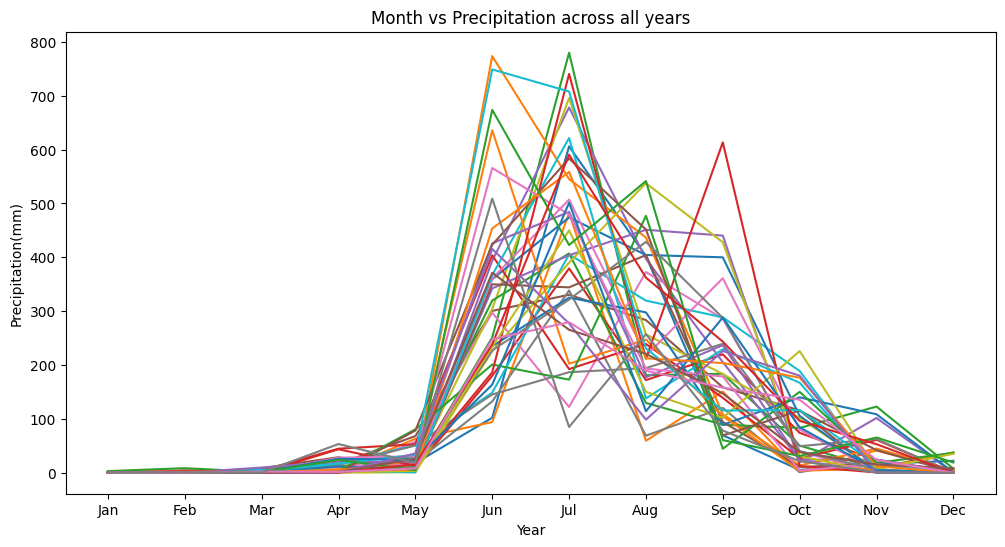

In [3]:
# Plotting the month vs precipitation for every year

plt.figure(figsize=(12,6))
plt.plot(rainfall_data_matrix)
plt.xlabel('Year')
plt.ylabel('Precipitation(mm)')
plt.title('Month vs Precipitation across all years')
plt.show()

**Inference:**\
June to October is the period of most rainfall

Text(0.5, 1.0, 'Month vs Precipitation across all years')

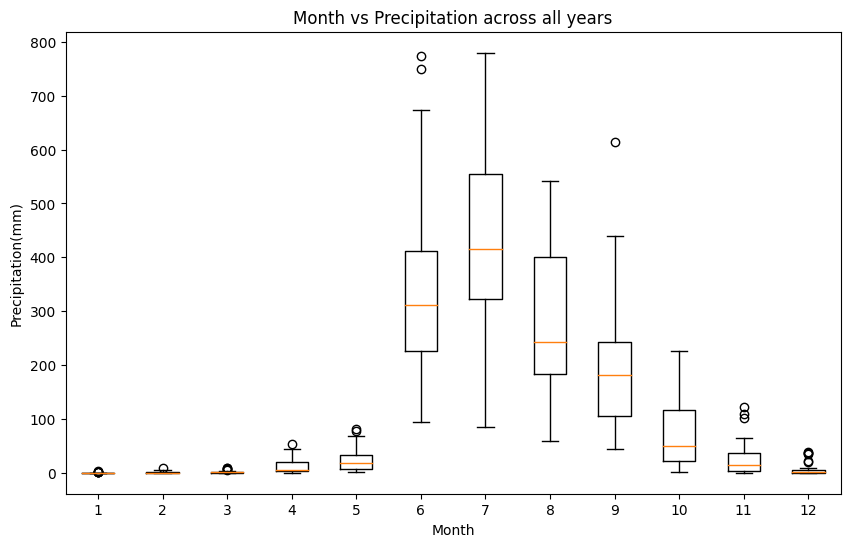

In [4]:
# Testing the above inference

rainfall_data_matrix = rainfall_data_matrix.transpose()
plt.figure(figsize=(10,6))
plt.boxplot(rainfall_data_matrix)
plt.xlabel('Month')
plt.ylabel('Precipitation(mm)')
plt.title('Month vs Precipitation across all years')

As we can see from above, the months from 6 (June) to 10 (October) have the highest values in the boxplot.


---




In [5]:
# # Creating monthly dates to assign the values of each month to their respective date

rainfall_data_matrix = rainfall_data_matrix.transpose()
dates = pd.date_range(start='1965-01', freq='MS', periods=len(rainfall_data_matrix.columns)*12)
dates

DatetimeIndex(['1965-01-01', '1965-02-01', '1965-03-01', '1965-04-01',
               '1965-05-01', '1965-06-01', '1965-07-01', '1965-08-01',
               '1965-09-01', '1965-10-01',
               ...
               '2002-03-01', '2002-04-01', '2002-05-01', '2002-06-01',
               '2002-07-01', '2002-08-01', '2002-09-01', '2002-10-01',
               '2002-11-01', '2002-12-01'],
              dtype='datetime64[ns]', length=456, freq='MS')

In [6]:
# Update the dataset with the dates and create our test data

rainfall_data_matrix_np = rainfall_data_matrix.transpose().values
shape = rainfall_data_matrix_np.shape
rainfall_data_matrix_np = rainfall_data_matrix_np.reshape((shape[0] * shape[1], 1))
rainfall_data = pd.DataFrame({'Precipitation': rainfall_data_matrix_np[:,0]})
rainfall_data.set_index(dates, inplace=True)
test_rainfall_data = rainfall_data.loc['1995': '2002']
rainfall_data = rainfall_data.loc[: '1994']
rainfall_data = rainfall_data.round(5)
rainfall_data.head()

,Precipitation
1965-01-01,0.029
1965-02-01,0.069
1965-03-01,0.000
1965-04-01,21.667
1965-05-01,17.859


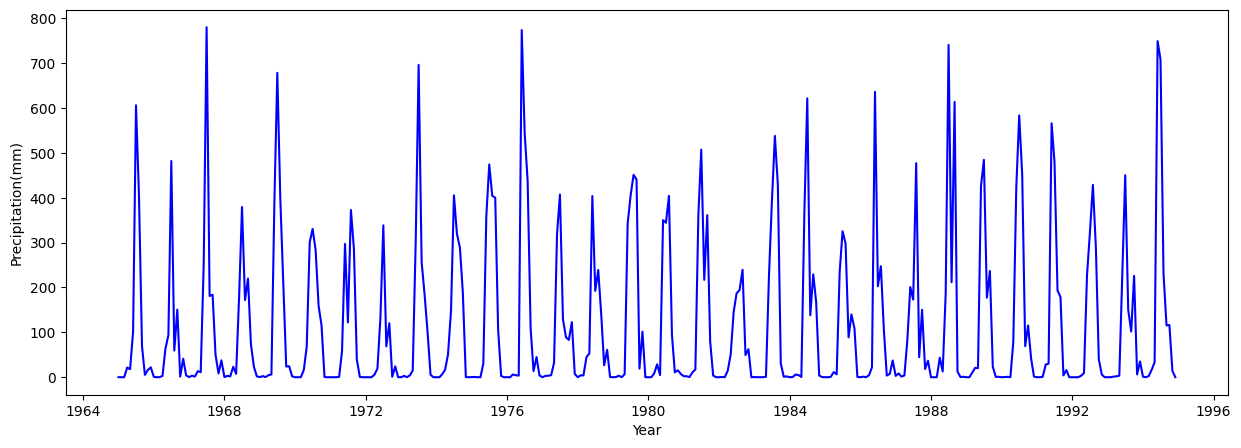

In [7]:
# Plotting the year vs precipitation

plt.figure(figsize=(15,5))
plt.plot(rainfall_data, color='blue')
plt.xlabel('Year')
plt.ylabel('Precipitation(mm)')
plt.show()

**Long Short Term Memory Model (LSTM)**\
We choose this model as it has the ability to remember important things about the input they received, which enables them to be more precise in predicting what is going to come next.

In [8]:
# Scaling the data to improve performance

scaler = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(rainfall_data)
test_data = scaler.fit_transform(test_rainfall_data)
print("Shape of train data: " + str(train_data.shape))
print("Shape of test data: " + str(test_data.shape))

Shape of train data: (360, 1)
Shape of test data: (96, 1)


In [9]:
# Coparing the datasets before and after scaling

display(scaler.inverse_transform(train_data[:5]))
display(train_data[:5])

array([[ 0.0250525 ],
       [ 0.05960767],
       [ 0.        ],
       [18.71767176],
       [15.42801957]])

array([[3.71792012e-05],
       [8.84608580e-05],
       [0.00000000e+00],
       [2.77779915e-02],
       [2.28959777e-02]])

In [10]:
# Convert time series data into input and labels

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
look_back = 11
trainX, trainY = create_dataset(train_data, look_back)
testX, testY = create_dataset(test_data, look_back)
testY

array([3.11650844e-05, 2.37448262e-05, 4.12417950e-03, 1.29112493e-04,
       9.37623826e-03, 7.61912111e-03, 6.73176212e-01, 8.28970469e-01,
       3.15344649e-01, 3.02215244e-01, 2.61892077e-01, 1.81083981e-02,
       0.00000000e+00, 1.90552230e-03, 0.00000000e+00, 1.10858657e-03,
       3.54866428e-02, 6.92161684e-03, 1.00000000e+00, 6.27624731e-01,
       8.03731203e-01, 8.97509910e-02, 4.60798034e-02, 9.70451048e-02,
       2.81836247e-02, 1.18724131e-05, 3.96390193e-03, 1.08335770e-04,
       5.59487468e-04, 2.33248396e-02, 3.54108078e-01, 8.76574393e-01,
       5.37756500e-01, 3.61283467e-01, 1.42949790e-01, 7.86027951e-02,
       5.19418074e-05, 0.00000000e+00, 2.12367790e-03, 0.00000000e+00,
       9.52761152e-04, 5.31706021e-02, 6.16580419e-01, 4.11285619e-01,
       1.46351236e-01, 3.35339276e-01, 2.67574511e-01, 3.90305581e-04,
       4.89737041e-05, 0.00000000e+00, 2.52288779e-04, 0.00000000e+00,
       1.77047361e-03, 3.89370629e-02, 5.51069927e-01, 3.93892534e-01,
      

In [11]:
# The first dimension would be reduced due to using the current and previous 10 data points in loop_back, the second dimension is of the loop_back

print("Shape of train input: " + str(trainX.shape))
print("Shape of train labels: " + str(trainY.shape))
print("Shape of test input: " + str(testX.shape))
print("Shape of test labels: " + str(testY.shape))

Shape of train input: (348, 11)
Shape of train labels: (348,)
Shape of test input: (84, 11)
Shape of test labels: (84,)


In [12]:
# Reshaping the data

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print("Shape of train input: " + str(trainX.shape))
print("Shape of train labels: " + str(trainY.shape))
print("Shape of test input: " + str(testX.shape))
print("Shape of test labels: " + str(testY.shape))

Shape of train input: (348, 1, 11)
Shape of train labels: (348,)
Shape of test input: (84, 1, 11)
Shape of test labels: (84,)


In [13]:
# Create model using Keras

model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [14]:
# Creating an early stopping model

from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='loss', patience = 10, mode = 'min', restore_best_weights=True)
history = model.fit(trainX, trainY, epochs=2000, verbose=2, callbacks = [es])

Epoch 1/2000
11/11 - 11s - loss: 0.0673 - 11s/epoch - 1s/step
Epoch 2/2000
11/11 - 0s - loss: 0.0610 - 52ms/epoch - 5ms/step
Epoch 3/2000
11/11 - 0s - loss: 0.0556 - 45ms/epoch - 4ms/step
Epoch 4/2000
11/11 - 0s - loss: 0.0514 - 46ms/epoch - 4ms/step
Epoch 5/2000
11/11 - 0s - loss: 0.0480 - 50ms/epoch - 5ms/step
Epoch 6/2000
11/11 - 0s - loss: 0.0451 - 48ms/epoch - 4ms/step
Epoch 7/2000
11/11 - 0s - loss: 0.0426 - 48ms/epoch - 4ms/step
Epoch 8/2000
11/11 - 0s - loss: 0.0402 - 58ms/epoch - 5ms/step
Epoch 9/2000
11/11 - 0s - loss: 0.0382 - 55ms/epoch - 5ms/step
Epoch 10/2000
11/11 - 0s - loss: 0.0364 - 75ms/epoch - 7ms/step
Epoch 11/2000
11/11 - 0s - loss: 0.0347 - 93ms/epoch - 8ms/step
Epoch 12/2000
11/11 - 0s - loss: 0.0331 - 49ms/epoch - 4ms/step
Epoch 13/2000
11/11 - 0s - loss: 0.0319 - 65ms/epoch - 6ms/step
Epoch 14/2000
11/11 - 0s - loss: 0.0308 - 55ms/epoch - 5ms/step
Epoch 15/2000
11/11 - 0s - loss: 0.0298 - 55ms/epoch - 5ms/step
Epoch 16/2000
11/11 - 0s - loss: 0.0289 - 61ms/epo

In [15]:
# Making predictions

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
testY.shape

3/3 [==============================] - 0s 4ms/step


(84,)

In [16]:
# Processing the outputs

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [17]:
# Calculating the Root Squared Mean Error

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 83.62 RMSE
Test Score: 105.26 RMSE


In [18]:
# Creating the dates

dates = pd.date_range(start='1965-04', freq='MS', periods=trainY.shape[1])

In [19]:
# Storing the training predictions into a dataframe

trainActual = pd.DataFrame({'Precipitation': trainY[0]})
trainActual.index = dates
trainPredictdf = pd.DataFrame({'Precipitation': trainPredict[:,0]})
trainPredictdf.index = dates

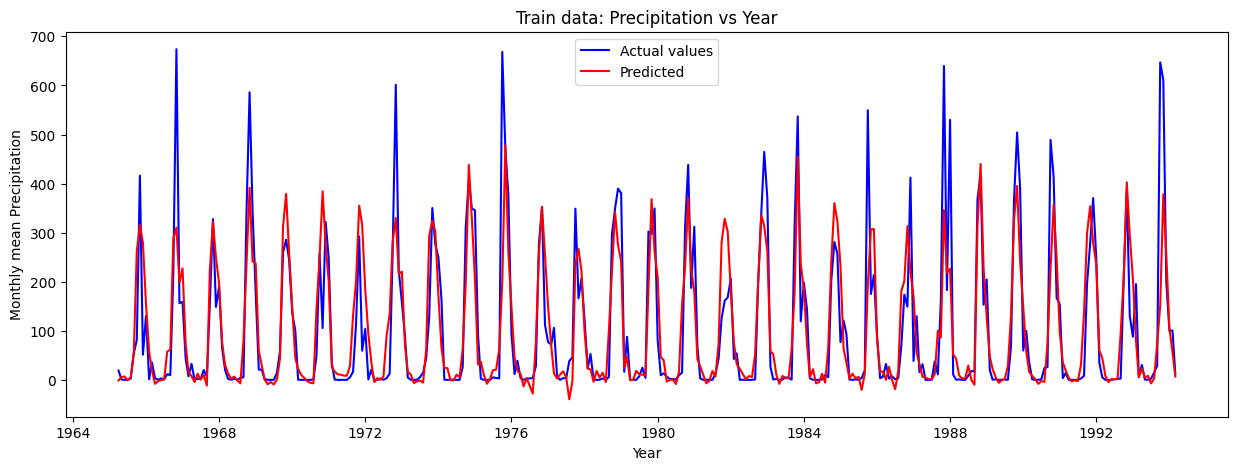

In [20]:
# Printing the training predictions

plt.figure(figsize=(15,5))
plt.plot(trainActual, color='blue', label='Actual values')
plt.plot(trainPredictdf, color='red', label='Predicted')
plt.title('Train data: Precipitation vs Year')
plt.xlabel('Year')
plt.ylabel('Monthly mean Precipitation')
plt.legend(loc='best')

In [21]:
# Storing the testing predictions into a dataframe

testDates = pd.date_range(start=test_rainfall_data.index[0] + pd.tseries.offsets.MonthEnd(11), freq='MS', periods=test_rainfall_data.shape[0] - 11 - 1)
testActual = pd.DataFrame({'Precipitation': testY[0]})
testActual.index = testDates
testPredictdf = pd.DataFrame({'Precipitation': testPredict[:,0]})
testPredictdf.index = testDates

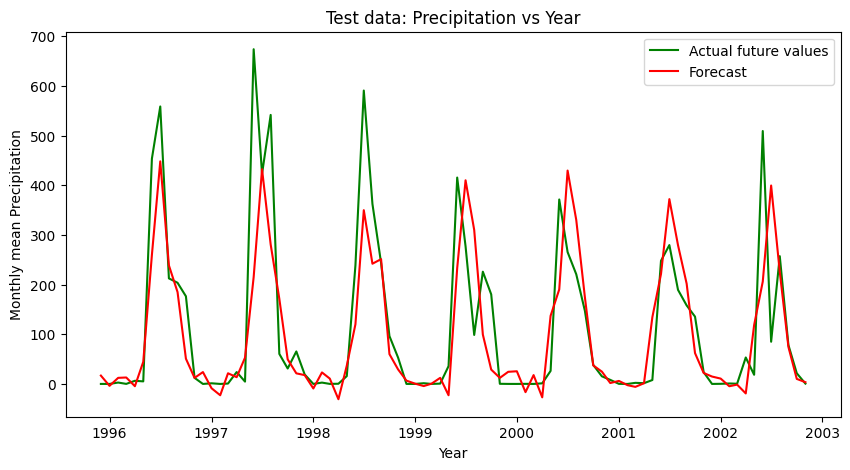

In [22]:
# Printing the testing predictions

plt.figure(figsize=(10,5))
plt.plot(testActual, color='green', label='Actual future values')
plt.plot(testPredictdf, color='red', label='Forecast')
plt.title('Test data: Precipitation vs Year')
plt.xlabel('Year')
plt.ylabel('Monthly mean Precipitation')
plt.legend(loc='best')

**Conclusion:**\
Even though the RMSE scores were not amazing, the graphs show a more or less similar trend in the amount of precipitation that occured except the middle months of 1998.